# Homework 4/Final Project

In [1]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from scipy import stats
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif','serif':['Palatino'],'size': 18})
rc('text', usetex=True)
rc('lines', **{'linewidth':3.0})
rc('axes', **{'labelsize':22})

## Part 1: Gaussian Process Regression to Fix Images

### Part a)

The sum of the differences is: -58865.857164382935


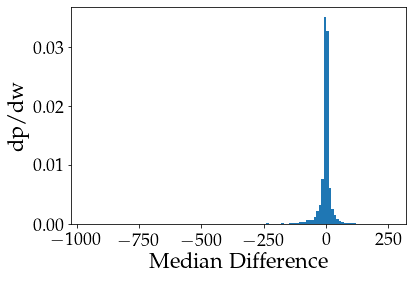

In [3]:
images = fits.open('image_cropped.fits')[0].data

# Function for finding adjacent points. Used nested for loops to find coordinates and made sure input arrays and coordinates
# are valid
def find_adjacent_points(arr, coords):
    if(arr.ndim != 2):
        raise ValueError("Called find_adjacent_points with array of incorrect dimension. Must have two dimensions.")
    
    if((coords[0] >= np.size(arr, axis=0)) or (coords[0] < 0) or (coords[1] >= np.size(arr, axis=1)) or (coords[1] < 0)):
        raise ValueError("Coordinates of designated pixel value must be within bounds of arr.")
    
    res = np.array([])
    for dx in range(-1, 2):
        for dy in range(-1, 2):
            if((0 <= coords[0] + dx <= np.size(arr, axis=0) - 1) and (0 <= coords[1] + dy <= np.size(arr, axis=1) - 1)
              and (dx != 0 or dy != 0)):
                res = np.append(res, arr[coords[0] + dx, coords[1] + dy])
    return res

# Function that finds the median of surrounding points for randomly chosen point. Uses the previous function and returns
# difference in median and actual pixel value.
def find_median_diff(N):
    rand_image = []
    rand_pixel = []
    rand_pix_val = []
    neighbor_median = []
    
    for i in range(N):
        rand_image.append(images[np.random.randint(0, np.size(images, axis=0))])
        rand_pixel.append(np.random.randint(0, np.size(rand_image[i], axis=0), size=2))
        rand_pix_val.append(rand_image[i][int(rand_pixel[i][0])][int(rand_pixel[i][1])])
        neighbor_median.append(np.median(find_adjacent_points(rand_image[i], 
                                                              [int(rand_pixel[i][0]), int(rand_pixel[i][1])])))
    differences = np.array(neighbor_median)-np.array(rand_pix_val)
    return differences

# The following lines show the results of median substitution for random points.
N = 10000
differences = find_median_diff(N)
sum_diff = np.sum(differences)
print("The sum of the differences is: " + str(sum_diff))

plt.hist(differences, bins=np.arange(np.amin(differences), np.amax(differences), 10), density=True)
plt.xlabel("Median Difference")
plt.ylabel("dp/dw")
plt.show()

### Part b)

The sum of the residuals is: -644246.6932054458


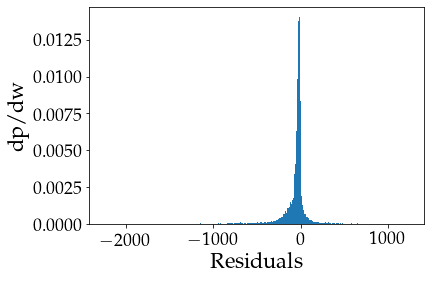

In [8]:
# Covariance function for the pixels.
def K(x1, x2, y1, y2, a, h):
    _x1, _x2 = np.meshgrid(x1, x2)
    _y1, _y2 = np.meshgrid(y1, y2)
    return a**2*np.exp(-((_x1-_x2)**2+(_y1-_y2)**2)/(2*h**2))

# This function generates residuals from the randomly sampled points. Finds neighboring grid with pixel of focus centered in
# grid. The neighboring grid is calculated according to the size parameter, and the a and h hyperparameters are tunable to
# achieve best results. N denotes the number of samples obtained.
def generate_residuals(N, size, a, h):
    residuals = np.zeros(N)
    
    sig_data = 1
    Cov_data = np.identity(size**2-1)*sig_data**2
    
    for i in range(N):
        rand_img = np.random.randint(0, np.size(images, axis=0))
        rand_coords = np.random.randint(size/2, np.size(images, axis=1)-(size+1)/2, 2)
        rand_pix_val = images[rand_img, rand_coords[0], rand_coords[1]]

        pnt_range_x = np.arange(rand_coords[0]-int(size/2), rand_coords[0]+int((size+1)/2))
        pnt_range_y = np.arange(rand_coords[1]-int(size/2), rand_coords[1]+int((size+1)/2))
        indices = np.meshgrid(pnt_range_x, pnt_range_y, indexing='ij')
        d = np.sqrt((indices[0]-rand_coords[0])**2+(indices[1]-rand_coords[1])**2)
        dist = d[d != 0]

        pnts = images[rand_img, pnt_range_x[:,None], pnt_range_y[None,:]]
        pnts_flat = np.ravel(pnts)
        surrounding_pnts = np.delete(pnts_flat, int((size**2-1)/2))
        
        Kinv = np.linalg.inv(K(np.delete(indices[0], int(size**2/2)), np.delete(indices[0], int(size**2/2)),
                               np.delete(indices[1], int(size**2/2)), np.delete(indices[1], int(size**2/2)),
                               a, h) + Cov_data)
        
        pnts_val_mean = np.linalg.multi_dot([K(np.delete(indices[0], int(size**2/2)), 
                                            np.delete(indices[0], int(size**2/2)), np.delete(indices[1], int(size**2/2)),
                                            np.delete(indices[1], int(size**2/2)), a, h), Kinv, surrounding_pnts])

        residuals[i] = pnts_val_mean[0]-rand_pix_val
    return residuals

# Below are the results arising from Gaussian Process Regression used to estimate center points.
a = 1
h = 1
residuals = generate_residuals(10000, 9, a, h)
sum_resid = np.sum(residuals)
print("The sum of the residuals is: " + str(sum_resid))

plt.hist(residuals, bins=np.arange(np.amin(residuals), np.amax(residuals), 10), density=True)
plt.xlabel("Residuals")
plt.ylabel("dp/dw")
plt.show()

### Part c)

The sum of the residuals is: -56103.49183302983


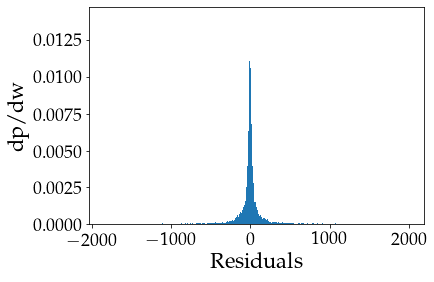

In [11]:
# Here are the resulting residuals from varying the hyperparameters. I found that varying h higher than 5 did not yield
# distinguishable results so opted to choose that. The same can be said for a. The results of the variation are shown below.
a = 10
h = 5
residuals = generate_residuals(10000, 9, a, h)
sum_resid = np.sum(residuals)
print("The sum of the residuals is: " + str(sum_resid))

plt.hist(residuals, bins=np.arange(np.amin(residuals), np.amax(residuals), 10), density=True)
plt.xlabel("Residuals")
plt.ylabel("dp/dw")
plt.show()

### Part d)

The sum of the residuals is: -40076.236375357796


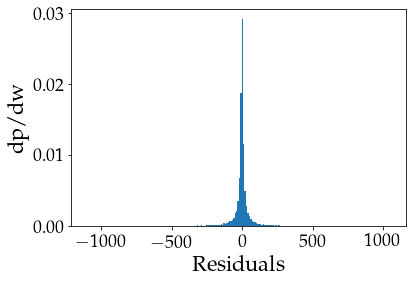

In [12]:
# This time, I varied grid size and showed the results below.
residuals = generate_residuals(10000, 3, a, h)
sum_resid = np.sum(residuals)
print("The sum of the residuals is: " + str(sum_resid))

plt.hist(residuals, bins=np.arange(np.amin(residuals), np.amax(residuals), 10), density=True)
plt.xlabel("Residuals")
plt.ylabel("dp/dw")
plt.show()

> As seen above, we get that the smallest patch that produces indistinguishable results from the 9x9 patch is a 3x3 patch. It reduces the sum of the residuals and greatly cuts down computational time.

### Part e)

In [16]:
# Below is a brief analysis of the effectiveness of Gaussian Process Regression over Median Substitution. I used the ratio
# of the two to determine the effectiveness of GPR over the other. The results were printed.
abs_resid_median_sub = abs(sum_diff)
abs_resid_gpr = abs(sum_resid)
ratio = abs_resid_median_sub/abs_resid_gpr
print("The ratio in the summed residuals from Median Substitution to Gaussian Process Regression is given by: " + str(ratio)
     + " which shows that the Gaussian Process Regression model performs better than the median substition by a factor of "
     "around " + str(round(ratio, 1)) + ". The ideal performance factor for Gaussian Process Regression with respect to "
     "Median Substition is around 3, showing that our ratio is slightly worse than ideal.")

The ratio in the summed residuals from Median Substitution to Gaussian Process Regression is given by: 1.468846939943157 which shows that the Gaussian Process Regression model performs better than the median substition by a factor of around 1.5. The ideal performance factor for Gaussian Process Regression with respect to Median Substition is around 3, showing that our ratio is slightly worse than ideal.


## Part 2: A Mixture Model and Bootstrapping, Redux

### Part a)
> For this mixture model, we will use a bivariate Gaussian distribution in order to estimate $\Delta\dot{x}$, $\Delta\dot{y}$, $a$, and $b$. With this in mind, we get the likelihood of the two dimensional mixture model as the following:
> $$\mathcal{L_i}=\frac{g}{2\pi\sqrt{(a^2(\sigma_{x,i}^{\prime2}+\sigma_{x,i}^{\prime\prime2}+2b^2)(a^2(\sigma_{y,i}^{\prime2}+\sigma_{y,i}^{\prime\prime2})+2b^2)}}exp\biggr(-\frac{1}{2}\biggr(\frac{(\dot{x_i^{\prime}}-\dot{x_i^{\prime\prime}}-\Delta\dot{x})^2}{a^2(\sigma_{x,i}^{\prime2}+\sigma_{x,i}^{\prime\prime2})+2b^2}+\frac{\dot{y_i^{\prime}}-\dot{y_i^{\prime\prime}}-\Delta\dot{y}}{a^2(\sigma_{y,i}^{\prime2}+\sigma_{y,i}^{\prime\prime2})+2b^2})\biggr)+\frac{1-g}{2\pi\sqrt{(4a^2(\sigma_{x,i}^{\prime2}+\sigma_{x,i}^{\prime\prime2})+2b^2)(4a^2(\sigma_{y,i}^{\prime2}+\sigma_{y,i}^{\prime\prime2})+2b^2)}}exp\biggr(-\frac{1}{2}\biggr(\frac{(\dot{x_i^{\prime}}-\dot{x_i^{\prime\prime}}-\Delta\dot{x})^2}{4a^2(\sigma_{x,i}^{\prime2}+\sigma_{x,i}^{\prime\prime2})+2b^2}+\frac{\dot{y_i^{\prime}}-\dot{y_i^{\prime\prime}}-\Delta\dot{y}}{4a^2(\sigma_{y,i}^{\prime2}+\sigma_{y,i}^{\prime\prime2})+2b^2})\biggr)$$

In [17]:
# Below is the log likelihood of the Gaussian Mixture Model given the bivariate Gaussian given above. Parameters given are
# the parameters of interest (\delta\dot{x}, \delta\dot{y}, a, and b), g (probability of a non-outlier), and the remaining
# parameters of the function are the data for the model along with their errors.
def log_like_2D(p, g, ra1, ra1_errs, dec1, dec1_errs, ra2, ra2_errs, dec2, dec2_errs):
    A_good = 1/(2*np.pi*np.sqrt((p[2]**2*(ra1_errs**2+ra2_errs**2)+2*p[3]**2)*(p[2]**2*(ra1_errs**2+ra2_errs**2)+2*p[3]**2)))
    gauss_ra_good = np.exp(-0.5*(ra1-ra2-p[0])**2/(p[2]**2*(ra1_errs**2+ra2_errs**2)+2*p[3]**2))
    gauss_dec_good = np.exp(-0.5*(dec1-dec2-p[1])**2/(p[2]**2*(ra1_errs**2+ra2_errs**2)+2*p[3]**2))
    good = g*A_good*gauss_ra_good*gauss_dec_good
    
    A_bad = 1/(2*np.pi*np.sqrt((4*p[2]**2*(ra1_errs**2+ra2_errs**2)+2*p[3]**2)*(4*p[2]**2*(ra1_errs**2+ra2_errs**2)+2*p[3]**2)))
    gauss_ra_bad = np.exp(-0.5*(ra1-ra2-p[0])**2/(4*p[2]**2*(ra1_errs**2+ra2_errs**2)+2*p[3]**2))
    gauss_dec_bad = np.exp(-0.5*(dec1-dec2-p[1])**2/(4*p[2]**2*(ra1_errs**2+ra2_errs**2)+2*p[3]**2))
    bad = (1-g)*A_bad*gauss_ra_bad*gauss_dec_bad
    
    return -np.sum(np.log(good+bad))

### Part b)

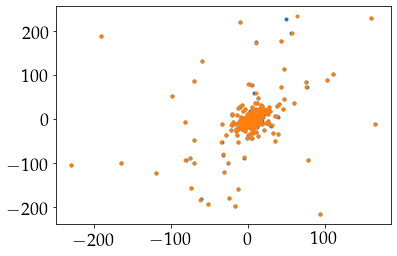

The approximate probability of a good value is: 0.8910891089108911


In [18]:
# Below is the code that reads in the data from the file, and plots them to get a good visualization of proportion of
# outliers
filepath = r"C:\Users\Rohit Penumarti\Desktop\UCSB\Spring 2020\PHYS 240\velocities.dat"
data = np.loadtxt(filepath)

x_dot1 = data[:, 0]
x1_errs = data[:, 1]
y_dot1 = data[:, 2]
y1_errs = data[:, 3]
x_dot2 = data[:, 4]
x2_errs = data[:, 5]
y_dot2 = data[:, 6]
y2_errs = data[:, 7]

plt.plot(x_dot1, y_dot1, '.')
plt.plot(x_dot2, y_dot2, '.')
plt.show()

# Here I estimate the proportion of outliers for the model. I estimate that non-outlier proper motions are within the range
# -50 to 50. The priors are then calculated using this amount. I feel while this is not perfectly accurate, they produce
# better, more robust priors than using 0.5 for both.
approx_non_out1 = x_dot1[np.logical_and(np.logical_and(y_dot1>=-50, y_dot1<=50), np.logical_and(x_dot1>=-50, x_dot1<=50))]
approx_non_out2 = x_dot2[np.logical_and(np.logical_and(y_dot2>=-50, y_dot2<=50), np.logical_and(x_dot2>=-50, x_dot2<=50))]
approx_non_out = np.average([np.size(approx_non_out1), np.size(approx_non_out2)])
g = approx_non_out/np.size(x_dot1)
print("The approximate probability of a good value is: " + str(g))

In [19]:
# Minimization of log-likelihood to achieve the best fit parameters.
res = optimize.minimize(log_like_2D, x0=[0.07, -0.15, 4, -8], 
                        args=(g, x_dot1, x1_errs, y_dot1, y1_errs, x_dot2, x2_errs, y_dot2, y2_errs,)).x
print("The estimated parameter values for the 2D mixture model are: " + str(res))

The estimated parameter values for the 2D mixture model are: [ 7.00007324e-02 -1.48471025e-01  4.08973067e+00 -8.05328199e-09]


### Part c)

In [20]:
# Here is a bootstrap resampling routine where I produce samples of the data and sample priors from the given data. I run
# this routine for 10% of the total number of data points to achieve my standard deviations.
n_bootstrap = int(np.size(x_dot1)/10)
model = []
bootstrap_errs = np.zeros(4)

for i in range(n_bootstrap):
    i_sample = np.random.randint(0, len(x_dot1), len(x_dot1))
    ra1_sample = x_dot1[i_sample]
    ra1_err_sample = x1_errs[i_sample]
    dec1_sample = y_dot1[i_sample]
    dec1_err_sample = y1_errs[i_sample]
    ra2_sample = x_dot2[i_sample]
    ra2_err_sample = x2_errs[i_sample]
    dec2_sample = y_dot2[i_sample]
    dec2_err_sample = y2_errs[i_sample]
    
    approx_non_out1_sample = ra1_sample[np.logical_and(np.logical_and(dec1_sample>=-50, dec1_sample<=50), 
                                                   np.logical_and(ra1_sample>=-50, ra1_sample<=50))]
    approx_non_out2_sample = ra2_sample[np.logical_and(np.logical_and(dec2_sample>=-50, dec2_sample<=50), 
                                                   np.logical_and(ra2_sample>=-50, ra2_sample<=50))]
    approx_non_out_sample = np.average([np.size(approx_non_out1_sample), np.size(approx_non_out2_sample)])
    g_sample = np.size(approx_non_out_sample)/np.size(ra1_sample)
    
    model.append(optimize.minimize(log_like_2D, x0=[0.07, -0.15, 4, -8], 
                                 args=(g_sample, ra1_sample, ra1_err_sample, dec1_sample, dec1_err_sample, ra2_sample, 
                                       ra2_err_sample, dec2_sample, dec2_err_sample)).x)

# This block of code prints out the results from the bootstrapping routine
model_arr = np.array(model)
for i in range(4):
    bootstrap_errs[i] = np.std(model_arr[:, i])
print("Using a bootstrap resampling method, I obtain standard errors of: " + str(bootstrap_errs) 
      + " for each respective parameter.")

Using a bootstrap resampling method, I obtain standard errors of: [0.02112154 0.02323368 0.49537456 0.11347682] for each respective parameter.


## Part 3: Measure your Evidence, Watch your Assumptions

In [25]:
# Here I am assuming that the sample size is 19, the likelihood ratio of a black hole is 10 versus none which is one, and
# that the number of parameters for the models with black holes as 3 and two for the ones without since the black hole is a
# free parameter. I then measure the BIC and AIC using the formulas on wikipedia and find the strength of each.
N = 19
max_like_black_hole = 1
max_like_no_black_hole = 1/10
k_black_hole = 3
k_no_black_hole = 2

BIC_black_hole = k_black_hole*np.log(N)-2*np.log(max_like_black_hole)
AIC_black_hole = 2*(k_black_hole-np.log(max_like_black_hole))

BIC_no_black_hole = k_no_black_hole*np.log(N)-2*np.log(max_like_no_black_hole)
AIC_no_black_hole = 2*(k_no_black_hole-np.log(max_like_no_black_hole))

delta_BIC = BIC_black_hole-BIC_no_black_hole
delta_AIC = AIC_black_hole-AIC_no_black_hole

print("The significance of the black hole in terms of the BIC is: " + str(delta_BIC))
print("The significance of the black hole in terms of the AIC is: " + str(delta_AIC))

strength_BIC = np.exp(delta_BIC)
strength_AIC = np.exp(delta_AIC)

print("The strength of the evidence in favor of the black hole using the BIC is: " + str(strength_BIC))
print("The strength of the evidence in favor of the black hole using the AIC is: " + str(strength_AIC))
print("It is clear in both scenarios, that the model with no black hole is preferred in either criterion")

The significance of the black hole in terms of the BIC is: -1.6607312068216498
The significance of the black hole in terms of the AIC is: -2.60517018598809
The strength of the evidence in favor of the black hole using the BIC is: 0.19000000000000022
The strength of the evidence in favor of the black hole using the AIC is: 0.0738905609893066
It is clear in both scenarios, that the model with no black hole is preferred in either criterion


> The probability that the authors will assign to the black hole having zero mass will be zero since they are using a lognormal distribution and that will cause zero to have a far lower probability of occuring. Instead of fitting using a lognormal distribution, they should have used the posterior probability distribution that they calculated in Figure 4b). Using that would be far more accurate than the lognormal and would give a greater possibility to zero being the mass.